In [1]:
"""
model: Neural Language Models (Bengio et al. 2003) URL: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Dimension key:
# windows
B: batch size
T: sequence length

# input/output
V: vocabulary size
E: embedding dimension
D: model dimension
"""
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# from jaxtyping import ...
g = torch.Generator().manual_seed(1337) # for .randn()

B, T = 32, 3
V, E, D = 27, 10, 200

# step: 0/200000, loss 27.63208770751953
# -> expected loss = nll = p(c) = -torch.tensor(1/V=27).log() = 3.2958
# -> self.W = torch.randn() is sampling from N(0, 1)
# -> just initialize weights with gain/sqrt(D_in) or torch.init_kaimingnormal()

# residuals + normalization + Adam/RMSprop has made initialization less fragile
# -> b/c initialization is fragile/intractable with *deep* neural networks

class Linear:
    def __init__(self, D_in, D_out, bias=True):
        self.W_DiDo = torch.randn((D_in, D_out), generator=g) * (5/3)/D_in**0.5 # kaiming init (He et al. 2015)
        self.b_Do = torch.zeros(D_out) if bias else None

    def __call__(self, X_Di):
        self.X_Do = X_Di @ self.W_DiDo
        if self.b_Do is not None:
            self.X_Do += self.b_Do
        # hidden layer:                 h(x; W) := W_D(l-1)D(l) @ X
        # hidden layer + batchorm    h(x, b; W) := W_D(l-1)D(l) @ batch_norm(X_b)
        #                batchnorm(X_b) = batch_gamma + (X_batch-mew)/sigma + batch_beta (Ioffe, Szegedy 2015)
        
        # -> batchnorm performs activation-distribution-agnostic normalization by normalizing initial weights to unit gaussian
        # -> fragility of kaiming initialization wrt different *activation functions* and *deeper networks* isn't as crucical
            # -> random batch is effectively regularizing by introducing some entropy (jitter) in the distribution of activations
            # -> alternatives to batchnorm have been proposed to decouple h as a function from the batch: layernorm, instancenorm, groupnorm
        self.X_Do = b_gamma + (self.X_Do - self.X_Do.mean(0, keepdim=True))/self.X_Do.std(0, keepdim=True) + b_beta # batchnorm: .mean() and .std() are differentiable.
        return self.X_Do

    def parameters(self):
        return [self.W_DiDo] + ([] if self.b_Do is None else [self.b_Do])

class Tanh:
    def __call__(self, X_BD):
        self.X_BD = torch.tanh(X_BD)
        # plt.hist(self.X_BD.view(-1).tolist(), 50); # distribution of weights
        # plt.imshow(self.X_BD.abs() > 0.99, cmap='gray', interpolation='nearest') # vanishing gradients
        self.out = self.X_BD
        return self.X_BD
    
    def parameters(self):
        return []

model = [
    Linear(T * E, D), Tanh(),
    Linear(D, D), Tanh(),
    Linear(D, V),
]

C = torch.randn((V,E), generator=g)
params = [C] + [p for l in model for p in l.parameters()]
for p in params:
    p.requires_grad = True

mooose torch.Size([1, 200])
mooose torch.Size([1, 200])
mooose torch.Size([1, 27])


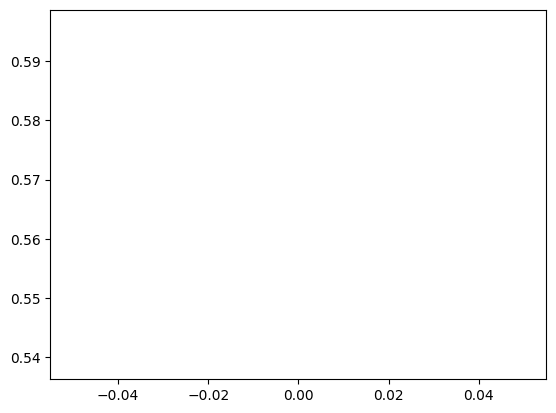

In [2]:
# 1. dataloader
import torch.nn.functional as F
import random

words = open('./data/names.txt', 'r').read().splitlines()
v = sorted(list(set(''.join(words))))
encode = { c:i+1 for i,c in enumerate(v) }
encode['.'] = 0
decode = { i:c for c,i in encode.items() }

context_length = 3
def gen_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_length;
        for c in w + '.':
            X.append(context)
            Y.append(encode[c])
            # print(''.join(decode[i] for i in context), '-->', decode[encode[c]])
            context = context[1:] + [encode[c]]
    X, Y = torch.tensor(X), torch.tensor(Y) # X:(N,C) Y:(N)
    return X, Y

random.seed(42)
random.shuffle(words)
n1, n2 = int(0.8*len(words)), int(0.9*len(words))
Xtr, Ytr = gen_dataset(words[:n1])
Xdev, Ydev = gen_dataset(words[n1:n2])
Xte, Yte = gen_dataset(words[n2:])

# 2. training loop
N = Xtr.shape[0]
losses, steps = [], []
for step in range(200000):
    # 1. forward
    indices_B = torch.randint(0, N, (B,))
    X_B, Y_B = Xtr[indices_B], Ytr[indices_B]

    X_BD = C[X_B].view(-1, T * E)
    for layer in model:
        X_BD = layer(X_BD)
    loss = F.cross_entropy(X_BD, Y_B)

    # 2. backward
    for layer in model:
        layer.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    # 3. update
    for p in params:
        p.data += -0.01 * p.grad

    steps.append(step)
    losses.append(loss.log10().item())
    break
    if step % 10000 == 0:
        print(f"step: {step}/{200000}, loss {loss.item()}")

plt.plot(steps, losses)

# generalization
# @torch.no_grad() # this decorator disables gradient tracking
# def split_loss(split):
#   x,y = {
#     'train': (Xtr, Ytr),
#     'val': (Xdev, Ydev),
#     'test': (Xte, Yte),
#   }[split]
#   emb = C[x] # (N, block_size, n_embd)
#   x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
#   for layer in layers:
#     x = layer(x)
#   loss = F.cross_entropy(x, y)
#   print(split, loss.item())

In [3]:
# # inference loop
# i_terminal = 0
# for _ in range(20):
#     output = []
#     context = [0] * context_length
#     while True:
#         emb = C[torch.tensor([context])]
#         x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
#         for l in model:
#           x = l(x)
#         logits = x
#         y_hat = F.softmax(logits, dim=1)

#         i = torch.multinomial(y_hat, num_samples=1, replacement=True, generator=g).item()
#         context = context[1:] + [i]
#         output.append(decode[i])
#         if i == i_terminal:
#             break
#     print(''.join(output))